# DCGAN

본 실습에서는 DCGAN에 대해 배워보겠습니다. 본 실습에서는 많은 실제 유명인의 사진을 사용해 새로운 사람의 사진을 생성하는 GAN을 훈련시킬 것입니다.

# 0. Requirements

In [ ]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


# 1. Generative Adversarial Networks

## 1.1. GAN

GAN은 training 데이터의 분포를 포착하여 동일한 분포로부터의 새로운 데이터를 생성할 수 있는 모델을 학습하는 프레임워크입니다. GAN은 generator와 discriminator로 구성이 되어 있습니다. Generator의 일은 training 데이터와 유사한 '가짜' 이미지를 만들어내는 것입니다. Discriminator의 일은 이미지를 본 뒤, 실제 training 데이터인지 generator로부터 생성된 가짜 이미지인지를 판별하는 것입니다. Training 동안, generator는 끊임없이 더 나은 가짜 이미지를 생성해 disciminator를 속이려 하고, discriminator는 진짜 이미지와 generator가 생성한 이미지를 더 잘 분류하기 위해 학습됩니다. 이 게임의 균형은 generator가 training 데이터에서 나온 듯한 완벽한 가짜 이미지를 만들어 내고 있을 때, discriminator는 항상 generator의 결과가 진짜인지 가짜인지 50%의 신뢰도를 가지고 추측할때 이뤄집니다.

몇 가지 notation을 정의하겠습니다. 먼저 $x$는 이미지 데이터를 의미합니다. 본 실습에서 다루는 이미지의 크기는 3 * 64 * 64입니다. $D(x)$는 discriminator 네트워크를 의미합니다. $D(x)$의 input은 이미지 데이터셋에서 나온 이미지거나 generator가 생성한 이미지가 됩니다. $D(x)$는 binary classifier로 생각할 수 있습니다. 만약 $x$가 real 이미지일 경우 $D(x)$는 높은 값을 가질 것입니다. Generator $G(z)$는 latent vector $z$를 input으로 받아 가짜 이미지를 생성합니다. $D(G(z))$는 generator의 output이 real 이미지로 판별될 확률을 의미합니다. GAN의 loss function은 다음과 같습니다.

$$
\min_G \max_D V(D,G) = 
\mathbb{E}_{x\sim p_{data}(x)}[\log D(x)]+
\mathbb{E}_{z\sim p_{z}(z)}[\log (1-D(G(x)))]
$$

이론적으로 이 minmax 게임의 solution은 $p_g = p_{data}$이며, 이때 discriminator는 input이 진짜인지 가짜인지를 랜덤하게 추측합니다. 하지만 GAN의 수렴은 여전히 활발히 연구되는 중이며 실제로 모델들은 항상 이 시점까지 훈련되지 않습니다.



# 2. Inputs
실행을 위해 몇 가지 input 들을 정의해줍시다.

- `dataroot` - 데이터셋 폴더의 경로
- `workers` - Dataloader를 이용해 데이터를 로드하기 위해 사용되는 스레드 수
- `batch_size` - 학습에서 사용되는 배치 크기
- `image_size` - 학습에서 사용되는 이미지 크기. 디폴트 값은 64 * 64이며, 다른 크기로 이용하기 위해서는 D와 G의 구조를 바꾸어야 합니다.
- `nc` - Input 이미지의 색상 채널 수. 컬러 이미지는 이 값이 3입니다.
- `nz` - Latent vector의 길이
- `ngf` - Generator를 거치는 피쳐 맵의 크기
- `gdf` - Discriminator를 거치는 피쳐 맵의 크기
- `num_epochs` - Training epoch의 수.
- `lr` - 학습에서 사용되는 learning rate.
- `beta1` - Adam optimizer를 위한 하이퍼파라미터입니다.

In [ ]:
# Root directory for dataset
dataroot = "data_faces"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# 3. Data
다음 코드를 실행해 실습에 사용할 데이터를 받습니다.

In [ ]:
!mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip 

--2022-04-21 02:01:43--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.192.48
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.192.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip’

celeba.zip          100%[===================>]   1.34G  58.4MB/s    in 38s     

2022-04-21 02:02:21 (36.0 MB/s) - ‘celeba.zip’ saved [1443490838/1443490838]



받은 데이터의 압축을 풀어줍니다. 본 실습에 사용될 데이터는 202599개의 이미지 데이터입니다.

In [ ]:
import zipfile

with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")

import os
root = 'data_faces/img_align_celeba'
img_list = os.listdir(root)
print(len(img_list))

202599


이제 우리는 dataset을 만들고, dataloader를 만들고, 실행되도록 device를 설정한 뒤 마지막으로 훈련 데이터를 시각화합니다.

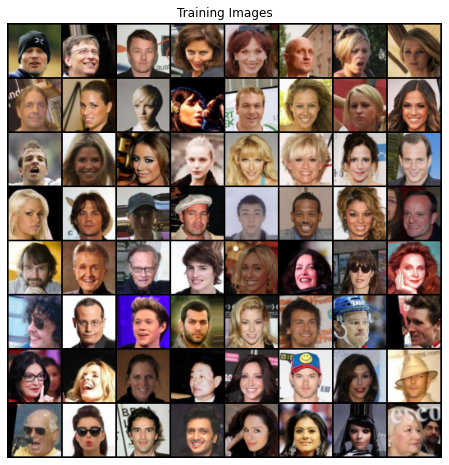

In [ ]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# 4. DCGAN

## 4.1. Weight Initialization

모델의 weight는 평균 0, 표준편차 0.02의 정규 분포에서 랜덤 하게 초기화시킵니다. `weights_init` 함수는 초기화된 모델을 input으로 가지고 모든 convolutional, convolutional-transpose, 그리고 batch-normalization layer를 이 기준에 맞게 재초기화시킵니다. 이 함수는 초기화된 직후의 모델에 적용됩니다.

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## 4.2. Generator

Generator, $G$는 latent vector $z$를 data-space로 매핑하도록 디자인되었습니다. 우리의 데이터는 이미지이기 때문에, $z$를 data-space로 변환하는 것은 학습 데이터와 같은 사이즈(3 * 64 * 64)의 RGB 이미지를 만드는 것과 같습니다. 실제로, 이것은 2d batch norm layer와 Relu 활성화 함수와 짝을 이루는 2차원의 strided convolutional transpose layer들을 통해 이루어집니다. Input 데이터의 범위를 [-1,1]로 조정하기 위해 generator의 output은 tanh 함수를 거칩니다. Conv-transpose layer 뒤에 Batch norm function이 위치합니다. 다음 그림은 generator를 도식화 한 것입니다.

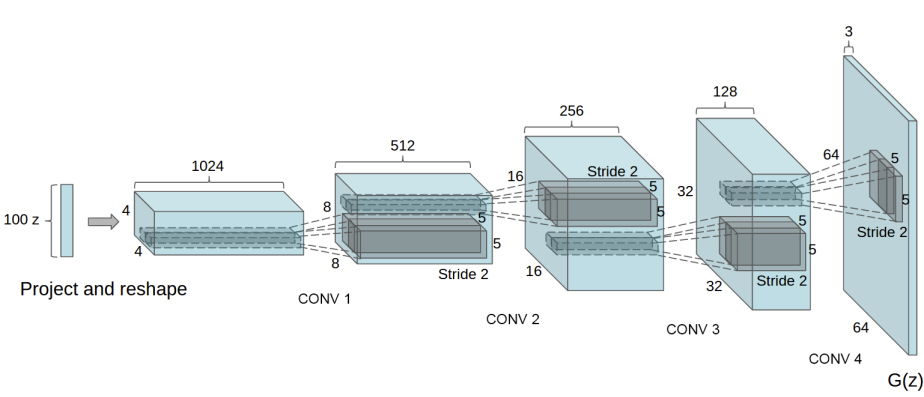

In [ ]:
# Generator Code

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

이제, 우리는 generator를 인스턴스화하고 `weights_init` 함수를 적용합니다.

In [ ]:
# Create the generator
netG = Generator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


## 4.3. Discriminator

Discriminator, $D$는 이미지를 input으로, input 이미지가 진짜일 확률을 output으로 하는 binary classification 네트워크입니다. $D$는 3 * 64 * 64 이미지를 입력받아, 여러 개의 Conv2d layer, BatchNorm2d layer, LeakyReLU layer를 지나고, 최종적으로 Sigmoid 함수를 거친 확률 값을 output으로 출력합니다.

### 연습

직접 discriminator를 완성시켜 봅시다. 완성시킨 코드의 결과는 다음과 같습니다.

out:
```
Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)
```


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        ## Start your code
        self.main = None
        ##End your code

    def forward(self, input):
        return self.main(input)

# Create the Discriminator
netD = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)        

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


## 4.4. Loss Functions and Optimizers

Loss function은 Binary Cross Entropy loss (BCELoss)를 이용합니다. BCELoss의 식은 다음과 같습니다.

$$
l(x,y)=L=\{l_1,...,l_N\}^\top
$$

$$
l_n=-[y_n\cdot \log x_n+(1-y_n)\cdot \log(1-x_n)]
$$

다음으로, 우리는 진짜 사진에 대한 라벨을 1, 가짜 사진에 대한 라벨을 0으로 정의합니다. 이 라벨은 $D$와 $G$의 loss를 계산할 때 이용됩니다. 최종적으로, 우리는 $D$와 $G$ 각각을 위한 두 개의 optimizer를 둡니다. 두 optimizer 모두 Adam optimizer이며, learning rate = 0.0002 , Beta1 = 0.5입니다. Generator의 학습 과정을 추적하기 위해, 우리는 가우시안 분포에서 온 고정된 배치 사이즈의 잠재 벡터를 생성할 것입니다. 학습 과정에서 우리는 주기적으로 이 fixed_noise 벡터를 $G$에 입력해, 이 벡터로부터 생성된 이미지를 확인할 것입니다.

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# 5. Training

잘못된 하이퍼 파라미터를 설정할 경우 mode collapse로 이어지기 때문에 GAN의 하이퍼 파라미터 설정은 까다롭습니다. 우리는 진짜 이미지와 가짜 이미지에 대한 각기 다른 미니 배치를 구성할 것이고 또한 G의 목적 함수를 log(D(G(z))를 최대화하는 것으로 조정할 것입니다. 학습은 두 개의 메인 파트로 나뉩니다. 파트 1은 $D$를 업데이트하는 것이고, 파트 2는 $G$를 업데이트하는 것입니다.

## 5.1. Part 1 - Train the Discriminator
Discriminator의 목적은 input으로 주어진 진짜 혹은 가짜 이미지를 올바르게 분류할 확률을 학습하는 것입니다. 우리는 discriminator의 stochastic gradient를 상승시킴으로써 업데이트 시킵니다. 우리는 $log(D(x))+log(1-D(G(z)))$를 극대화하고자 합니다다. 이를 위해 우리는 두 단계로 나누어 계산을 할 것입니다. 첫째, training 데이터로부터 진짜 샘플을 가져와 batch를 구성한 뒤 $D$를 거치게 해 loss를 계산합니다.($logD(x)$) 그리고 backward pass로 gradient를 계산합니다. 둘째, 우리는 현재의 generator로 만든 가짜 샘플로 batch를 구성한 뒤 $D$를 거치게 할 것입니다. 그리고 loss를 계산하고($log(1-D(G(z))$) gradient를 계산합니다. 이제 모든 진짜 이미지, 가짜 이미지 batch에서의 gradient를 모두 합해 discriminator의 opitimizer의 `step`을 호출합니다.

## 5.2. Part 2 - Train the Generator
우리는 더 나은 가짜 이미지를 만들기 위해  $log(1-D(G(z)))$를 최소화함으로써 generator를 훈련시키고자 합니다. 하지만 이것은 특히나 학습 초기에 충분한 gradient를 제공하지 못합니다. 이를 해결하기 위해 우리는 $log(D(G(z)))$를 최대화하는 방향으로 학습을 진행하겠습니다. 이를 위하여 다음과 같은 과정을 거칩니다. 먼저 generator의 output을 discriminator로 분류합니다. 그 후, 실제 label을 ground truth로 사용하여 $G$의 loss를 계산합니다. 이를 바탕으로 $G$의 gradient를 계산하고 최종적으로 $G$의 파라미터를 업데이트 합니다.

훈련과정에서 보여주는 값들은 다음과 같습니다.
- `Loss_D` - 모든 진짜, 가짜 이미지 배치에 대한 loss를 합한 값
- `Loss_G` - log(D(G(z)))로 계산된 generator loss
- `D(x)` - 진짜 이미지 배치에 대한 discriminator의 평균 아웃풋. 1에 가깝게 시작해서, G가 나아질수록 이론적으로 0.5에 수렴하게 됩니다. 
- `D(G(z))` - 가짜 이미지 배치에 대한 discriminator의 평균 아웃풋. 첫 번째 값은 D가 업데이트되기 전, 두 번째 값은 D가 업데이트된 후의 숫자입니다. 이 숫자들은 0에 가깝게 시작해서 G가 나아질수록 0.5에 가깝게 됩니다.

학습은 약 20분이 소요됩니다.

In [ ]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:
start = time.time()

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]    \tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

now = time.time()
s = now - start
print(asMinutes(s))

Starting Training Loop...
[1/5][0/1583]    	Loss_D: 1.3465	Loss_G: 6.6685	D(x): 0.6945	D(G(z)): 0.5372 / 0.0025
[1/5][50/1583]    	Loss_D: 0.0688	Loss_G: 8.7695	D(x): 0.9589	D(G(z)): 0.0067 / 0.0004
[1/5][100/1583]    	Loss_D: 0.2329	Loss_G: 10.7998	D(x): 0.9378	D(G(z)): 0.0981 / 0.0000
[1/5][150/1583]    	Loss_D: 0.2357	Loss_G: 3.0207	D(x): 0.9133	D(G(z)): 0.0906 / 0.0758
[1/5][200/1583]    	Loss_D: 1.3021	Loss_G: 4.4452	D(x): 0.4074	D(G(z)): 0.0092 / 0.0403
[1/5][250/1583]    	Loss_D: 0.2947	Loss_G: 5.5112	D(x): 0.8626	D(G(z)): 0.0137 / 0.0178


# 6. Results

아래는 training iteration 별 $D$와 $G$의 loss를 나타낸 그래프입니다.

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

우리는 G의 학습 과정을 애니메이션으로 확인할 수 있습니다.

In [ ]:
from IPython.display import HTML
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

마지막으로, 진짜 이미지와 가짜 이미지를 옆에 두고 비교해봅시다.

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()